In [2]:
!pip install jovian --upgrade --quiet

In [3]:
!pip install opendatasets --upgrade
import opendatasets as od
dataset_url = 'https://www.kaggle.com/sshikamaru/fruit-recognition'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: manansodhi
Your Kaggle Key: ··········


  5%|▍         | 5.00M/102M [00:00<00:01, 51.3MB/s]

100%|██████████| 102M/102M [00:01<00:00, 90.8MB/s] 


In [4]:
#Import the libraries

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [5]:
project_name = 'pytorch-project'

In [6]:
#Check if GPU is available or not

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu:1")
print(device)

cuda:1


In [7]:
data_dir = '/content/fruit-recognition'

print(os.listdir(data_dir))

['sampleSubmission.csv', 'test', 'train']


In [8]:
dataset_train = ImageFolder(data_dir+"/train/train", transform=ToTensor())

In [9]:
len(dataset_train)

16854

In [10]:
#Check the size of the images

im_count = 0
for image,_ in dataset_train:
  im_count += 1
  print(image.shape)
  if im_count == 10:
    break 

torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])
torch.Size([3, 100, 100])


In [11]:
print('Total classes of Fruits:',len(dataset_train.classes))
print(dataset_train.classes)

Total classes of Fruits: 33
['Apple Braeburn', 'Apple Granny Smith', 'Apricot', 'Avocado', 'Banana', 'Blueberry', 'Cactus fruit', 'Cantaloupe', 'Cherry', 'Clementine', 'Corn', 'Cucumber Ripe', 'Grape Blue', 'Kiwi', 'Lemon', 'Limes', 'Mango', 'Onion White', 'Orange', 'Papaya', 'Passion Fruit', 'Peach', 'Pear', 'Pepper Green', 'Pepper Red', 'Pineapple', 'Plum', 'Pomegranate', 'Potato Red', 'Raspberry', 'Strawberry', 'Tomato', 'Watermelon']


In [12]:
def show_example(img,label):
  print('Label: ', classes[label], '('+str(label)+')')
  plt.imshow(img.permute(1, 2, 0))

In [13]:
#show_example(*dataset_train[10])

In [14]:
import jovian
jovian.commit(project = project_name)

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
API KEY: ··········
API KEY: ··········
API KEY: ··········
API KEY: ··········
API KEY: ··········
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/raghavsodhi02/pytorch-project


'https://jovian.ai/raghavsodhi02/pytorch-project'

In [15]:
random_seed = 0
torch.manual_seed(random_seed);

In [16]:
val_size = 5000
test_size = 1000
train_size = len(dataset_train) - val_size - test_size

data_train, data_val, data_test = random_split(dataset_train, [train_size, val_size, test_size])
len(data_train), len(data_val), len(data_test)

(10854, 5000, 1000)

In [17]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128

In [18]:
train_dl = DataLoader(data_train, batch_size, shuffle = True, num_workers= 4, pin_memory=True)
val_dl = DataLoader(data_val, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(data_test, batch_size*2, num_workers=4, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def show_batch(dl):
  for img, label in dl:
    fig, ax = plt.subplots(figsize = (16, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img, nrow = 16).permute(1,2,0))
    break

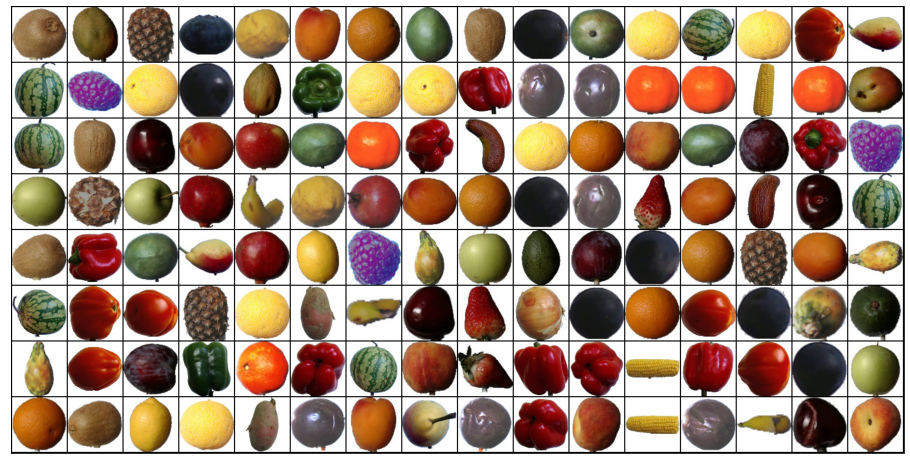

In [20]:
show_batch(train_dl)

In [21]:
jovian.commit(project = project_name)

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/raghavsodhi02/pytorch-project


'https://jovian.ai/raghavsodhi02/pytorch-project'


MODEL

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [23]:
sample_model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.MaxPool2d(2, 2)
)

In [24]:
for images, labels in train_dl:
    print("images shape: ", images.shape)
    out = sample_model(images)
    print("out shape", out.shape)
    break

images shape:  torch.Size([128, 3, 100, 100])
out shape torch.Size([128, 32, 50, 50])


In [25]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [26]:
class GenCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 64 x 50 x 50
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 128 x 25 x 25
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 256 x 12 x 12
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 512 x 6 x 6
            
            nn.Flatten(),
            nn.Linear(512*6*6, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 33))
        
    def forward(self, xb):
        return self.network(xb)

In [27]:
model = GenCnnModel()
model

GenCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [28]:
for images, labels in train_dl:
    print("images shape: ", images.shape)
    out = model(images)
    print("out shape: ", out.shape)
    print("out[0]: ", out[0])
    break

images shape:  torch.Size([128, 3, 100, 100])
out shape:  torch.Size([128, 33])
out[0]:  tensor([-0.0245,  0.0594,  0.0380, -0.0822,  0.0678,  0.0032,  0.1766, -0.0666,
         0.0267, -0.1242, -0.0593,  0.0273,  0.0654,  0.0837, -0.0383,  0.1163,
         0.0698,  0.1119, -0.0454,  0.0429, -0.1196, -0.0676, -0.0135,  0.1151,
         0.0432,  0.1136,  0.0557,  0.0743,  0.0878, -0.0410,  0.0153,  0.0032,
        -0.0741], grad_fn=<SelectBackward>)


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [30]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [31]:
train_loader = DeviceDataLoader(train_dl, device)
val_loader = DeviceDataLoader(val_dl, device)
test_loader = DeviceDataLoader(test_dl, device)
to_device(model, device);

In [32]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
model = to_device(GenCnnModel(), device)

In [34]:
model

GenCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

In [35]:
#Initial Accuracy of the model

evaluate(model, val_loader)

{'val_acc': 0.026079963892698288, 'val_loss': 3.4950408935546875}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [37]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': num_epochs,
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [ ]:
history = fit(num_epochs, lr, model, train_loader, val_loader, opt_func)

Epoch [0], train_loss: 3.3049, val_loss: 2.7191, val_acc: 0.1177
Epoch [1], train_loss: 2.1949, val_loss: 1.5951, val_acc: 0.3763
Epoch [2], train_loss: 1.3196, val_loss: 0.8752, val_acc: 0.6509
Epoch [3], train_loss: 0.6488, val_loss: 0.5148, val_acc: 0.8093
Epoch [4], train_loss: 0.3487, val_loss: 0.1896, val_acc: 0.9294
Epoch [5], train_loss: 0.1983, val_loss: 0.1241, val_acc: 0.9553
Epoch [6], train_loss: 0.1092, val_loss: 0.0443, val_acc: 0.9868
Epoch [7], train_loss: 0.0821, val_loss: 0.0307, val_acc: 0.9903
Epoch [8], train_loss: 0.0298, val_loss: 0.0183, val_acc: 0.9967


In [ ]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

In [ ]:
plot_accuracies(history)

In [ ]:
plot_losses(history)

In [ ]:
jovian.commit(project=project_name)

In [ ]:
result = evaluate(model, test_loader)
result

In [ ]:
jovian.log_metrics(test_loss=result['val_loss'], test_acc=result['val_acc'])

In [ ]:
torch.save(model.state_dict(), 'genClass-Cnn.pth')

In [ ]:
model2 = to_device(GenCnnModel(), device)

In [ ]:
model2.load_state_dict(torch.load('genClass-Cnn.pth'))

In [ ]:
evaluate(model2, test_loader)

In [ ]:
jovian.commit(project=project_name)